# Convolutional autoencoders and LSTMs for PDE surrogates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

# For ML construction
from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Reshape
from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model

# For filtering 
from scipy.signal import savgol_filter #1D
from scipy.ndimage import gaussian_filter #nd

### Grab data from Github

In [ ]:
!wget -O train.npy https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/AE_and_GAN/Science_Data/train.npy?raw=true
!wget -O validation.npy https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/AE_and_GAN/Science_Data/validation.npy?raw=true
!wget -O SWE_CAE_Weights.h5 https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/AE_and_GAN/saved_models/SWE_CAE_Weights.h5?raw=true
!wget -O SWE_LSTM_Weights.h5 https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/AE_and_GAN/saved_models/SWE_LSTM_Weights.h5?raw=true

### Load SWE snapshot data into the proper arrays and rescale

In [2]:
swe_data = np.transpose(np.load('train.npy'))
swe_data_v = np.transpose(np.load('validation.npy'))

swe_train_data = np.zeros(shape=(400,64,64,3)) # Channels last
swe_valid_data = np.zeros(shape=(400,64,64,3)) # Channels last

for i in range(np.shape(swe_data)[0]):
    temp_1 = swe_data[i,0:64*64].reshape(64,64)
    temp_2 = swe_data[i,64*64:2*64*64].reshape(64,64)
    temp_3 = swe_data[i,2*64*64:3*64*64].reshape(64,64)
    swe_train_data[i,:,:,0] = np.transpose(temp_1[:,:])
    swe_train_data[i,:,:,1] = np.transpose(temp_2[:,:])
    swe_train_data[i,:,:,2] = np.transpose(temp_3[:,:])
    
for i in range(np.shape(swe_data)[0]):
    temp_1 = swe_data_v[i,0:64*64].reshape(64,64)
    temp_2 = swe_data_v[i,64*64:2*64*64].reshape(64,64)
    temp_3 = swe_data_v[i,2*64*64:3*64*64].reshape(64,64)
    swe_valid_data[i,:,:,0] = np.transpose(temp_1[:,:])
    swe_valid_data[i,:,:,1] = np.transpose(temp_2[:,:])
    swe_valid_data[i,:,:,2] = np.transpose(temp_3[:,:])

# Scale between 0 and 1
for j in range(3):
    swe_train_data[:,:,:,j] = (swe_train_data[:,:,:,j] - np.min(swe_train_data[:,:,:,0]))/(np.max(swe_train_data[:,:,:,0])-np.min(swe_train_data[:,:,:,0]))
    swe_valid_data[:,:,:,j] = (swe_valid_data[:,:,:,j] - np.min(swe_valid_data[:,:,:,0]))/(np.max(swe_valid_data[:,:,:,0])-np.min(swe_valid_data[:,:,:,0]))

### Visualize the data set

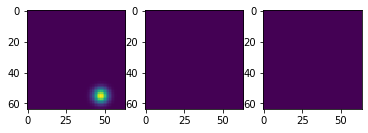

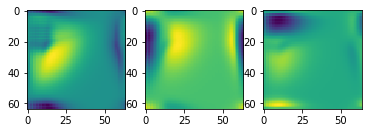

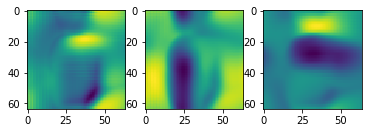

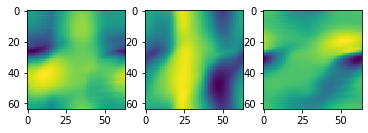

In [3]:
# Visualize multiple time instances
for time in range(0,200,50):
    fig, ax = plt.subplots(nrows=1,ncols=3)
    ax[0].imshow(swe_train_data[time,:,:,0])
    ax[1].imshow(swe_train_data[time,:,:,1])
    ax[2].imshow(swe_train_data[time,:,:,2])
    plt.show()

### Do a shift of the training data for one-step prediction in the future

In [4]:
# Do some shifting to allow for LSTM pipeline
swe_evolve_data = swe_train_data[1:]
swe_train_data = swe_train_data[:-1]

### ML Presets and Custom Functions

In [5]:
mode = 'train'
lrate = 0.001

def mean_absolute_error(y_pred,y_true):
    return K.mean(K.abs(y_true-y_pred))

def max_absolute_error(y_pred,y_true):
    return K.max(K.abs(y_true-y_pred))

### Autoencoder + LSTM pipeline

In [ ]:
## Define recursive model architecture
weights_filepath = 'Model_weights.h5'

# Encoder
encoder_inputs = Input(shape=(64,64,3),name='Field')

x = Conv2D(30,kernel_size=(3,3),activation='relu',padding='same')(encoder_inputs)
enc_l2 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(20,kernel_size=(3,3),activation='relu',padding='same')(enc_l2)
enc_l3 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(10,kernel_size=(3,3),activation='relu',padding='same')(enc_l3)
enc_l4 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(15,kernel_size=(3,3),activation='relu',padding='same')(enc_l4)
enc_l5 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(1,kernel_size=(3,3),activation=None,padding='same')(enc_l5)
encoded = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

# LSTM starts
x = Reshape((1,4))(encoded)
x = LSTM(20,input_shape=(1,4,),return_sequences=True)(x)
# x = LSTM(20,input_shape=(1,4,),return_sequences=True)(x)
x = Dense(4,activation=None)(x)
lstm_outputs = Reshape((2,2,1))(x)
  
# Decoder starts using LSTM pipeline
x = Conv2D(1,kernel_size=(3,3),activation='relu',padding='same')(lstm_outputs)
dec_l1 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(5,kernel_size=(3,3),activation='relu',padding='same')(dec_l1)
dec_l2 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(10,kernel_size=(3,3),activation='relu',padding='same')(dec_l2)
dec_l3 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(20,kernel_size=(3,3),activation='relu',padding='same')(dec_l3)
dec_l4 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(30,kernel_size=(3,3),activation='relu',padding='same')(dec_l4)
dec_l5 = UpSampling2D(size=(2, 2))(x)

ae_lstm_decoded = Conv2D(3,kernel_size=(3,3),activation=None,padding='same')(dec_l5)
    
# Decoder starts using pure autoencoder pipeline
x = Conv2D(1,kernel_size=(3,3),activation='relu',padding='same')(encoded)
dec_l1 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(5,kernel_size=(3,3),activation='relu',padding='same')(dec_l1)
dec_l2 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(10,kernel_size=(3,3),activation='relu',padding='same')(dec_l2)
dec_l3 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(20,kernel_size=(3,3),activation='relu',padding='same')(dec_l3)
dec_l4 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(30,kernel_size=(3,3),activation='relu',padding='same')(dec_l4)
dec_l5 = UpSampling2D(size=(2, 2))(x)

ae_decoded = Conv2D(3,kernel_size=(3,3),activation=None,padding='same')(dec_l5)

model = Model(inputs=encoder_inputs,outputs=[ae_decoded,ae_lstm_decoded],name='CAE')
   
# design network
my_adam = optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint]

# fit network
model.compile(optimizer=my_adam,loss='mean_squared_error',metrics=[mean_absolute_error,max_absolute_error])    
model.summary()

num_epochs = 500
batch_size = 4

if mode == 'train':
    train_history = model.fit(x=swe_train_data, 
                              y=[swe_train_data,swe_evolve_data], 
                              epochs=num_epochs, 
                              batch_size=batch_size, 
                              callbacks=callbacks_list,
                              validation_split = 0.1)

Model: "CAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Field (InputLayer)              [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 30)   840         Field[0][0]                      
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 30)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 20)   5420        max_pooling2d[0][0]              
________________________________________________________________________________________________

Epoch 2/500
89/90 [============================>.] - ETA: 0s - loss: 0.0095 - conv2d_16_loss: 0.0045 - conv2d_10_loss: 0.0049 - conv2d_16_mean_absolute_error: 0.0434 - conv2d_16_max_absolute_error: 0.6178 - conv2d_10_mean_absolute_error: 0.0453 - conv2d_10_max_absolute_error: 0.6205
Epoch 00002: val_loss did not improve from 0.00619
90/90 [==============================] - 3s 32ms/step - loss: 0.0095 - conv2d_16_loss: 0.0045 - conv2d_10_loss: 0.0050 - conv2d_16_mean_absolute_error: 0.0435 - conv2d_16_max_absolute_error: 0.6150 - conv2d_10_mean_absolute_error: 0.0454 - conv2d_10_max_absolute_error: 0.6177 - val_loss: 0.0065 - val_conv2d_16_loss: 0.0034 - val_conv2d_10_loss: 0.0031 - val_conv2d_16_mean_absolute_error: 0.0402 - val_conv2d_16_max_absolute_error: 0.1889 - val_conv2d_10_mean_absolute_error: 0.0397 - val_conv2d_10_max_absolute_error: 0.1626
Epoch 3/500
89/90 [============================>.] - ETA: 0s - loss: 0.0092 - conv2d_16_loss: 0.0043 - conv2d_10_loss: 0.0049 - conv2d_16

89/90 [============================>.] - ETA: 0s - loss: 0.0068 - conv2d_16_loss: 0.0034 - conv2d_10_loss: 0.0034 - conv2d_16_mean_absolute_error: 0.0386 - conv2d_16_max_absolute_error: 0.5706 - conv2d_10_mean_absolute_error: 0.0376 - conv2d_10_max_absolute_error: 0.5932
Epoch 00011: val_loss did not improve from 0.00407
90/90 [==============================] - 3s 37ms/step - loss: 0.0068 - conv2d_16_loss: 0.0034 - conv2d_10_loss: 0.0034 - conv2d_16_mean_absolute_error: 0.0386 - conv2d_16_max_absolute_error: 0.5663 - conv2d_10_mean_absolute_error: 0.0376 - conv2d_10_max_absolute_error: 0.5895 - val_loss: 0.0041 - val_conv2d_16_loss: 0.0024 - val_conv2d_10_loss: 0.0017 - val_conv2d_16_mean_absolute_error: 0.0339 - val_conv2d_16_max_absolute_error: 0.1867 - val_conv2d_10_mean_absolute_error: 0.0293 - val_conv2d_10_max_absolute_error: 0.1804
Epoch 12/500
89/90 [============================>.] - ETA: 0s - loss: 0.0065 - conv2d_16_loss: 0.0032 - conv2d_10_loss: 0.0032 - conv2d_16_mean_absol

Epoch 21/500
90/90 [==============================] - ETA: 0s - loss: 0.0053 - conv2d_16_loss: 0.0027 - conv2d_10_loss: 0.0026 - conv2d_16_mean_absolute_error: 0.0344 - conv2d_16_max_absolute_error: 0.5269 - conv2d_10_mean_absolute_error: 0.0335 - conv2d_10_max_absolute_error: 0.5200
Epoch 00021: val_loss did not improve from 0.00402
90/90 [==============================] - 4s 47ms/step - loss: 0.0053 - conv2d_16_loss: 0.0027 - conv2d_10_loss: 0.0026 - conv2d_16_mean_absolute_error: 0.0344 - conv2d_16_max_absolute_error: 0.5269 - conv2d_10_mean_absolute_error: 0.0335 - conv2d_10_max_absolute_error: 0.5200 - val_loss: 0.0048 - val_conv2d_16_loss: 0.0029 - val_conv2d_10_loss: 0.0019 - val_conv2d_16_mean_absolute_error: 0.0367 - val_conv2d_16_max_absolute_error: 0.2317 - val_conv2d_10_mean_absolute_error: 0.0304 - val_conv2d_10_max_absolute_error: 0.2284
Epoch 22/500
90/90 [==============================] - ETA: 0s - loss: 0.0051 - conv2d_16_loss: 0.0026 - conv2d_10_loss: 0.0026 - conv2d_

Epoch 31/500
89/90 [============================>.] - ETA: 0s - loss: 0.0046 - conv2d_16_loss: 0.0023 - conv2d_10_loss: 0.0023 - conv2d_16_mean_absolute_error: 0.0316 - conv2d_16_max_absolute_error: 0.5418 - conv2d_10_mean_absolute_error: 0.0310 - conv2d_10_max_absolute_error: 0.5325
Epoch 00031: val_loss did not improve from 0.00402
90/90 [==============================] - 4s 41ms/step - loss: 0.0046 - conv2d_16_loss: 0.0023 - conv2d_10_loss: 0.0023 - conv2d_16_mean_absolute_error: 0.0315 - conv2d_16_max_absolute_error: 0.5388 - conv2d_10_mean_absolute_error: 0.0310 - conv2d_10_max_absolute_error: 0.5297 - val_loss: 0.0048 - val_conv2d_16_loss: 0.0027 - val_conv2d_10_loss: 0.0022 - val_conv2d_16_mean_absolute_error: 0.0358 - val_conv2d_16_max_absolute_error: 0.2134 - val_conv2d_10_mean_absolute_error: 0.0321 - val_conv2d_10_max_absolute_error: 0.2560
Epoch 32/500
89/90 [============================>.] - ETA: 0s - loss: 0.0045 - conv2d_16_loss: 0.0023 - conv2d_10_loss: 0.0022 - conv2d_

Epoch 41/500
90/90 [==============================] - ETA: 0s - loss: 0.0041 - conv2d_16_loss: 0.0021 - conv2d_10_loss: 0.0020 - conv2d_16_mean_absolute_error: 0.0297 - conv2d_16_max_absolute_error: 0.4937 - conv2d_10_mean_absolute_error: 0.0285 - conv2d_10_max_absolute_error: 0.4903
Epoch 00041: val_loss did not improve from 0.00402
90/90 [==============================] - 4s 41ms/step - loss: 0.0041 - conv2d_16_loss: 0.0021 - conv2d_10_loss: 0.0020 - conv2d_16_mean_absolute_error: 0.0297 - conv2d_16_max_absolute_error: 0.4937 - conv2d_10_mean_absolute_error: 0.0285 - conv2d_10_max_absolute_error: 0.4903 - val_loss: 0.0045 - val_conv2d_16_loss: 0.0022 - val_conv2d_10_loss: 0.0022 - val_conv2d_16_mean_absolute_error: 0.0330 - val_conv2d_16_max_absolute_error: 0.1908 - val_conv2d_10_mean_absolute_error: 0.0317 - val_conv2d_10_max_absolute_error: 0.2832
Epoch 42/500
89/90 [============================>.] - ETA: 0s - loss: 0.0041 - conv2d_16_loss: 0.0021 - conv2d_10_loss: 0.0020 - conv2d_

Epoch 51/500
89/90 [============================>.] - ETA: 0s - loss: 0.0038 - conv2d_16_loss: 0.0020 - conv2d_10_loss: 0.0018 - conv2d_16_mean_absolute_error: 0.0288 - conv2d_16_max_absolute_error: 0.4992 - conv2d_10_mean_absolute_error: 0.0271 - conv2d_10_max_absolute_error: 0.5006
Epoch 00051: val_loss did not improve from 0.00402
90/90 [==============================] - 4s 41ms/step - loss: 0.0038 - conv2d_16_loss: 0.0020 - conv2d_10_loss: 0.0018 - conv2d_16_mean_absolute_error: 0.0288 - conv2d_16_max_absolute_error: 0.4960 - conv2d_10_mean_absolute_error: 0.0271 - conv2d_10_max_absolute_error: 0.4983 - val_loss: 0.0051 - val_conv2d_16_loss: 0.0023 - val_conv2d_10_loss: 0.0028 - val_conv2d_16_mean_absolute_error: 0.0335 - val_conv2d_16_max_absolute_error: 0.2240 - val_conv2d_10_mean_absolute_error: 0.0342 - val_conv2d_10_max_absolute_error: 0.3393
Epoch 52/500
89/90 [============================>.] - ETA: 0s - loss: 0.0037 - conv2d_16_loss: 0.0019 - conv2d_10_loss: 0.0018 - conv2d_

Epoch 61/500
89/90 [============================>.] - ETA: 0s - loss: 0.0036 - conv2d_16_loss: 0.0018 - conv2d_10_loss: 0.0017 - conv2d_16_mean_absolute_error: 0.0279 - conv2d_16_max_absolute_error: 0.5218 - conv2d_10_mean_absolute_error: 0.0262 - conv2d_10_max_absolute_error: 0.5166
Epoch 00061: val_loss did not improve from 0.00402
90/90 [==============================] - 3s 38ms/step - loss: 0.0036 - conv2d_16_loss: 0.0019 - conv2d_10_loss: 0.0017 - conv2d_16_mean_absolute_error: 0.0280 - conv2d_16_max_absolute_error: 0.5262 - conv2d_10_mean_absolute_error: 0.0263 - conv2d_10_max_absolute_error: 0.5206 - val_loss: 0.0051 - val_conv2d_16_loss: 0.0024 - val_conv2d_10_loss: 0.0026 - val_conv2d_16_mean_absolute_error: 0.0347 - val_conv2d_16_max_absolute_error: 0.2332 - val_conv2d_10_mean_absolute_error: 0.0348 - val_conv2d_10_max_absolute_error: 0.3044
Epoch 62/500
89/90 [============================>.] - ETA: 0s - loss: 0.0034 - conv2d_16_loss: 0.0018 - conv2d_10_loss: 0.0016 - conv2d_

Epoch 71/500
89/90 [============================>.] - ETA: 0s - loss: 0.0034 - conv2d_16_loss: 0.0017 - conv2d_10_loss: 0.0016 - conv2d_16_mean_absolute_error: 0.0271 - conv2d_16_max_absolute_error: 0.5136 - conv2d_10_mean_absolute_error: 0.0257 - conv2d_10_max_absolute_error: 0.5077
Epoch 00071: val_loss did not improve from 0.00402
90/90 [==============================] - 3s 38ms/step - loss: 0.0034 - conv2d_16_loss: 0.0018 - conv2d_10_loss: 0.0016 - conv2d_16_mean_absolute_error: 0.0272 - conv2d_16_max_absolute_error: 0.5106 - conv2d_10_mean_absolute_error: 0.0258 - conv2d_10_max_absolute_error: 0.5070 - val_loss: 0.0053 - val_conv2d_16_loss: 0.0024 - val_conv2d_10_loss: 0.0028 - val_conv2d_16_mean_absolute_error: 0.0345 - val_conv2d_16_max_absolute_error: 0.2528 - val_conv2d_10_mean_absolute_error: 0.0357 - val_conv2d_10_max_absolute_error: 0.3082
Epoch 72/500
89/90 [============================>.] - ETA: 0s - loss: 0.0031 - conv2d_16_loss: 0.0016 - conv2d_10_loss: 0.0015 - conv2d_

Epoch 81/500
89/90 [============================>.] - ETA: 0s - loss: 0.0030 - conv2d_16_loss: 0.0015 - conv2d_10_loss: 0.0015 - conv2d_16_mean_absolute_error: 0.0253 - conv2d_16_max_absolute_error: 0.4911 - conv2d_10_mean_absolute_error: 0.0244 - conv2d_10_max_absolute_error: 0.4777
Epoch 00081: val_loss did not improve from 0.00402
90/90 [==============================] - 4s 40ms/step - loss: 0.0030 - conv2d_16_loss: 0.0015 - conv2d_10_loss: 0.0015 - conv2d_16_mean_absolute_error: 0.0253 - conv2d_16_max_absolute_error: 0.4953 - conv2d_10_mean_absolute_error: 0.0244 - conv2d_10_max_absolute_error: 0.4811 - val_loss: 0.0050 - val_conv2d_16_loss: 0.0025 - val_conv2d_10_loss: 0.0025 - val_conv2d_16_mean_absolute_error: 0.0352 - val_conv2d_16_max_absolute_error: 0.2545 - val_conv2d_10_mean_absolute_error: 0.0351 - val_conv2d_10_max_absolute_error: 0.2624
Epoch 82/500
90/90 [==============================] - ETA: 0s - loss: 0.0029 - conv2d_16_loss: 0.0015 - conv2d_10_loss: 0.0014 - conv2d_

Epoch 91/500
89/90 [============================>.] - ETA: 0s - loss: 0.0028 - conv2d_16_loss: 0.0015 - conv2d_10_loss: 0.0013 - conv2d_16_mean_absolute_error: 0.0247 - conv2d_16_max_absolute_error: 0.4561 - conv2d_10_mean_absolute_error: 0.0235 - conv2d_10_max_absolute_error: 0.4360
Epoch 00091: val_loss did not improve from 0.00402
90/90 [==============================] - 3s 38ms/step - loss: 0.0028 - conv2d_16_loss: 0.0015 - conv2d_10_loss: 0.0013 - conv2d_16_mean_absolute_error: 0.0247 - conv2d_16_max_absolute_error: 0.4533 - conv2d_10_mean_absolute_error: 0.0235 - conv2d_10_max_absolute_error: 0.4337 - val_loss: 0.0057 - val_conv2d_16_loss: 0.0025 - val_conv2d_10_loss: 0.0031 - val_conv2d_16_mean_absolute_error: 0.0356 - val_conv2d_16_max_absolute_error: 0.2646 - val_conv2d_10_mean_absolute_error: 0.0383 - val_conv2d_10_max_absolute_error: 0.2974
Epoch 92/500
89/90 [============================>.] - ETA: 0s - loss: 0.0028 - conv2d_16_loss: 0.0015 - conv2d_10_loss: 0.0014 - conv2d_

Epoch 101/500
89/90 [============================>.] - ETA: 0s - loss: 0.0027 - conv2d_16_loss: 0.0014 - conv2d_10_loss: 0.0013 - conv2d_16_mean_absolute_error: 0.0242 - conv2d_16_max_absolute_error: 0.4717 - conv2d_10_mean_absolute_error: 0.0231 - conv2d_10_max_absolute_error: 0.4590
Epoch 00101: val_loss did not improve from 0.00402
90/90 [==============================] - 4s 41ms/step - loss: 0.0027 - conv2d_16_loss: 0.0014 - conv2d_10_loss: 0.0013 - conv2d_16_mean_absolute_error: 0.0242 - conv2d_16_max_absolute_error: 0.4762 - conv2d_10_mean_absolute_error: 0.0231 - conv2d_10_max_absolute_error: 0.4641 - val_loss: 0.0063 - val_conv2d_16_loss: 0.0030 - val_conv2d_10_loss: 0.0033 - val_conv2d_16_mean_absolute_error: 0.0377 - val_conv2d_16_max_absolute_error: 0.3238 - val_conv2d_10_mean_absolute_error: 0.0391 - val_conv2d_10_max_absolute_error: 0.3377
Epoch 102/500
89/90 [============================>.] - ETA: 0s - loss: 0.0027 - conv2d_16_loss: 0.0014 - conv2d_10_loss: 0.0013 - conv2

Epoch 111/500
89/90 [============================>.] - ETA: 0s - loss: 0.0026 - conv2d_16_loss: 0.0014 - conv2d_10_loss: 0.0012 - conv2d_16_mean_absolute_error: 0.0241 - conv2d_16_max_absolute_error: 0.4675 - conv2d_10_mean_absolute_error: 0.0231 - conv2d_10_max_absolute_error: 0.4483
Epoch 00111: val_loss did not improve from 0.00402
90/90 [==============================] - 4s 40ms/step - loss: 0.0026 - conv2d_16_loss: 0.0014 - conv2d_10_loss: 0.0012 - conv2d_16_mean_absolute_error: 0.0241 - conv2d_16_max_absolute_error: 0.4691 - conv2d_10_mean_absolute_error: 0.0231 - conv2d_10_max_absolute_error: 0.4498 - val_loss: 0.0061 - val_conv2d_16_loss: 0.0030 - val_conv2d_10_loss: 0.0031 - val_conv2d_16_mean_absolute_error: 0.0379 - val_conv2d_16_max_absolute_error: 0.3001 - val_conv2d_10_mean_absolute_error: 0.0382 - val_conv2d_10_max_absolute_error: 0.2995
Epoch 112/500
90/90 [==============================] - ETA: 0s - loss: 0.0025 - conv2d_16_loss: 0.0013 - conv2d_10_loss: 0.0012 - conv2

Epoch 121/500
89/90 [============================>.] - ETA: 0s - loss: 0.0024 - conv2d_16_loss: 0.0013 - conv2d_10_loss: 0.0011 - conv2d_16_mean_absolute_error: 0.0233 - conv2d_16_max_absolute_error: 0.4570 - conv2d_10_mean_absolute_error: 0.0221 - conv2d_10_max_absolute_error: 0.4310
Epoch 00121: val_loss did not improve from 0.00402
90/90 [==============================] - 3s 38ms/step - loss: 0.0024 - conv2d_16_loss: 0.0013 - conv2d_10_loss: 0.0011 - conv2d_16_mean_absolute_error: 0.0233 - conv2d_16_max_absolute_error: 0.4535 - conv2d_10_mean_absolute_error: 0.0220 - conv2d_10_max_absolute_error: 0.4278 - val_loss: 0.0061 - val_conv2d_16_loss: 0.0031 - val_conv2d_10_loss: 0.0031 - val_conv2d_16_mean_absolute_error: 0.0377 - val_conv2d_16_max_absolute_error: 0.3274 - val_conv2d_10_mean_absolute_error: 0.0375 - val_conv2d_10_max_absolute_error: 0.3286
Epoch 122/500
90/90 [==============================] - ETA: 0s - loss: 0.0024 - conv2d_16_loss: 0.0013 - conv2d_10_loss: 0.0012 - conv2

Epoch 131/500
90/90 [==============================] - ETA: 0s - loss: 0.0023 - conv2d_16_loss: 0.0012 - conv2d_10_loss: 0.0011 - conv2d_16_mean_absolute_error: 0.0229 - conv2d_16_max_absolute_error: 0.4441 - conv2d_10_mean_absolute_error: 0.0215 - conv2d_10_max_absolute_error: 0.4278
Epoch 00131: val_loss did not improve from 0.00402
90/90 [==============================] - 4s 41ms/step - loss: 0.0023 - conv2d_16_loss: 0.0012 - conv2d_10_loss: 0.0011 - conv2d_16_mean_absolute_error: 0.0229 - conv2d_16_max_absolute_error: 0.4441 - conv2d_10_mean_absolute_error: 0.0215 - conv2d_10_max_absolute_error: 0.4278 - val_loss: 0.0067 - val_conv2d_16_loss: 0.0031 - val_conv2d_10_loss: 0.0036 - val_conv2d_16_mean_absolute_error: 0.0380 - val_conv2d_16_max_absolute_error: 0.3264 - val_conv2d_10_mean_absolute_error: 0.0410 - val_conv2d_10_max_absolute_error: 0.3328
Epoch 132/500
90/90 [==============================] - ETA: 0s - loss: 0.0022 - conv2d_16_loss: 0.0012 - conv2d_10_loss: 0.0011 - conv2

Epoch 141/500
90/90 [==============================] - ETA: 0s - loss: 0.0023 - conv2d_16_loss: 0.0012 - conv2d_10_loss: 0.0011 - conv2d_16_mean_absolute_error: 0.0224 - conv2d_16_max_absolute_error: 0.4660 - conv2d_10_mean_absolute_error: 0.0219 - conv2d_10_max_absolute_error: 0.4477
Epoch 00141: val_loss did not improve from 0.00402
90/90 [==============================] - 4s 39ms/step - loss: 0.0023 - conv2d_16_loss: 0.0012 - conv2d_10_loss: 0.0011 - conv2d_16_mean_absolute_error: 0.0224 - conv2d_16_max_absolute_error: 0.4660 - conv2d_10_mean_absolute_error: 0.0219 - conv2d_10_max_absolute_error: 0.4477 - val_loss: 0.0063 - val_conv2d_16_loss: 0.0031 - val_conv2d_10_loss: 0.0032 - val_conv2d_16_mean_absolute_error: 0.0379 - val_conv2d_16_max_absolute_error: 0.3137 - val_conv2d_10_mean_absolute_error: 0.0387 - val_conv2d_10_max_absolute_error: 0.3193
Epoch 142/500
89/90 [============================>.] - ETA: 0s - loss: 0.0023 - conv2d_16_loss: 0.0012 - conv2d_10_loss: 0.0011 - conv2

Epoch 151/500
89/90 [============================>.] - ETA: 0s - loss: 0.0022 - conv2d_16_loss: 0.0011 - conv2d_10_loss: 0.0010 - conv2d_16_mean_absolute_error: 0.0221 - conv2d_16_max_absolute_error: 0.4685 - conv2d_10_mean_absolute_error: 0.0213 - conv2d_10_max_absolute_error: 0.4507
Epoch 00151: val_loss did not improve from 0.00402
90/90 [==============================] - 4s 39ms/step - loss: 0.0022 - conv2d_16_loss: 0.0011 - conv2d_10_loss: 0.0010 - conv2d_16_mean_absolute_error: 0.0221 - conv2d_16_max_absolute_error: 0.4655 - conv2d_10_mean_absolute_error: 0.0213 - conv2d_10_max_absolute_error: 0.4477 - val_loss: 0.0061 - val_conv2d_16_loss: 0.0030 - val_conv2d_10_loss: 0.0031 - val_conv2d_16_mean_absolute_error: 0.0378 - val_conv2d_16_max_absolute_error: 0.2802 - val_conv2d_10_mean_absolute_error: 0.0381 - val_conv2d_10_max_absolute_error: 0.3074
Epoch 152/500
89/90 [============================>.] - ETA: 0s - loss: 0.0023 - conv2d_16_loss: 0.0012 - conv2d_10_loss: 0.0011 - conv2

Epoch 161/500
89/90 [============================>.] - ETA: 0s - loss: 0.0021 - conv2d_16_loss: 0.0011 - conv2d_10_loss: 9.8519e-04 - conv2d_16_mean_absolute_error: 0.0222 - conv2d_16_max_absolute_error: 0.4240 - conv2d_10_mean_absolute_error: 0.0209 - conv2d_10_max_absolute_error: 0.4193
Epoch 00161: val_loss did not improve from 0.00402
90/90 [==============================] - 5s 55ms/step - loss: 0.0021 - conv2d_16_loss: 0.0011 - conv2d_10_loss: 9.9048e-04 - conv2d_16_mean_absolute_error: 0.0222 - conv2d_16_max_absolute_error: 0.4271 - conv2d_10_mean_absolute_error: 0.0209 - conv2d_10_max_absolute_error: 0.4194 - val_loss: 0.0063 - val_conv2d_16_loss: 0.0029 - val_conv2d_10_loss: 0.0034 - val_conv2d_16_mean_absolute_error: 0.0376 - val_conv2d_16_max_absolute_error: 0.2760 - val_conv2d_10_mean_absolute_error: 0.0403 - val_conv2d_10_max_absolute_error: 0.3099
Epoch 162/500
89/90 [============================>.] - ETA: 0s - loss: 0.0022 - conv2d_16_loss: 0.0011 - conv2d_10_loss: 0.0011

Epoch 171/500
89/90 [============================>.] - ETA: 0s - loss: 0.0020 - conv2d_16_loss: 0.0011 - conv2d_10_loss: 9.5998e-04 - conv2d_16_mean_absolute_error: 0.0216 - conv2d_16_max_absolute_error: 0.4317 - conv2d_10_mean_absolute_error: 0.0207 - conv2d_10_max_absolute_error: 0.4198
Epoch 00171: val_loss did not improve from 0.00402
90/90 [==============================] - 4s 44ms/step - loss: 0.0020 - conv2d_16_loss: 0.0011 - conv2d_10_loss: 9.6354e-04 - conv2d_16_mean_absolute_error: 0.0216 - conv2d_16_max_absolute_error: 0.4347 - conv2d_10_mean_absolute_error: 0.0207 - conv2d_10_max_absolute_error: 0.4245 - val_loss: 0.0064 - val_conv2d_16_loss: 0.0030 - val_conv2d_10_loss: 0.0034 - val_conv2d_16_mean_absolute_error: 0.0382 - val_conv2d_16_max_absolute_error: 0.2901 - val_conv2d_10_mean_absolute_error: 0.0397 - val_conv2d_10_max_absolute_error: 0.3215
Epoch 172/500
89/90 [============================>.] - ETA: 0s - loss: 0.0021 - conv2d_16_loss: 0.0010 - conv2d_10_loss: 0.0010

Epoch 181/500
89/90 [============================>.] - ETA: 0s - loss: 0.0020 - conv2d_16_loss: 0.0010 - conv2d_10_loss: 9.8235e-04 - conv2d_16_mean_absolute_error: 0.0215 - conv2d_16_max_absolute_error: 0.4421 - conv2d_10_mean_absolute_error: 0.0209 - conv2d_10_max_absolute_error: 0.4358
Epoch 00181: val_loss did not improve from 0.00402
90/90 [==============================] - 4s 40ms/step - loss: 0.0020 - conv2d_16_loss: 0.0010 - conv2d_10_loss: 9.8073e-04 - conv2d_16_mean_absolute_error: 0.0215 - conv2d_16_max_absolute_error: 0.4394 - conv2d_10_mean_absolute_error: 0.0209 - conv2d_10_max_absolute_error: 0.4334 - val_loss: 0.0068 - val_conv2d_16_loss: 0.0031 - val_conv2d_10_loss: 0.0036 - val_conv2d_16_mean_absolute_error: 0.0390 - val_conv2d_16_max_absolute_error: 0.3087 - val_conv2d_10_mean_absolute_error: 0.0416 - val_conv2d_10_max_absolute_error: 0.3426
Epoch 182/500
89/90 [============================>.] - ETA: 0s - loss: 0.0021 - conv2d_16_loss: 0.0011 - conv2d_10_loss: 0.0010

Epoch 191/500
89/90 [============================>.] - ETA: 0s - loss: 0.0021 - conv2d_16_loss: 0.0011 - conv2d_10_loss: 0.0010 - conv2d_16_mean_absolute_error: 0.0217 - conv2d_16_max_absolute_error: 0.4560 - conv2d_10_mean_absolute_error: 0.0212 - conv2d_10_max_absolute_error: 0.4459
Epoch 00191: val_loss did not improve from 0.00402
90/90 [==============================] - 3s 37ms/step - loss: 0.0021 - conv2d_16_loss: 0.0011 - conv2d_10_loss: 0.0010 - conv2d_16_mean_absolute_error: 0.0217 - conv2d_16_max_absolute_error: 0.4526 - conv2d_10_mean_absolute_error: 0.0211 - conv2d_10_max_absolute_error: 0.4423 - val_loss: 0.0066 - val_conv2d_16_loss: 0.0031 - val_conv2d_10_loss: 0.0035 - val_conv2d_16_mean_absolute_error: 0.0387 - val_conv2d_16_max_absolute_error: 0.3092 - val_conv2d_10_mean_absolute_error: 0.0406 - val_conv2d_10_max_absolute_error: 0.3276
Epoch 192/500
89/90 [============================>.] - ETA: 0s - loss: 0.0019 - conv2d_16_loss: 9.8351e-04 - conv2d_10_loss: 9.1717e-04

Epoch 201/500
89/90 [============================>.] - ETA: 0s - loss: 0.0019 - conv2d_16_loss: 0.0010 - conv2d_10_loss: 8.9455e-04 - conv2d_16_mean_absolute_error: 0.0213 - conv2d_16_max_absolute_error: 0.4554 - conv2d_10_mean_absolute_error: 0.0201 - conv2d_10_max_absolute_error: 0.4355
Epoch 00201: val_loss did not improve from 0.00402
90/90 [==============================] - 3s 37ms/step - loss: 0.0019 - conv2d_16_loss: 0.0010 - conv2d_10_loss: 9.1576e-04 - conv2d_16_mean_absolute_error: 0.0214 - conv2d_16_max_absolute_error: 0.4580 - conv2d_10_mean_absolute_error: 0.0202 - conv2d_10_max_absolute_error: 0.4419 - val_loss: 0.0065 - val_conv2d_16_loss: 0.0028 - val_conv2d_10_loss: 0.0037 - val_conv2d_16_mean_absolute_error: 0.0372 - val_conv2d_16_max_absolute_error: 0.2680 - val_conv2d_10_mean_absolute_error: 0.0423 - val_conv2d_10_max_absolute_error: 0.3196
Epoch 202/500
89/90 [============================>.] - ETA: 0s - loss: 0.0022 - conv2d_16_loss: 0.0011 - conv2d_10_loss: 0.0011

### Check accuracy of autoencoder

In [ ]:
time = 100

model.load_weights(weights_filepath)
recoded_1 = model.predict(swe_train_data[time:time+1,:,:,:])[0]

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(14,12))

cs1 = ax[0,0].imshow(swe_train_data[time,:,:,0],label='input')
ax[1,0].imshow(recoded_1[0,:,:,0],label='decoded')

cs2 = ax[0,1].imshow(swe_train_data[time,:,:,1],label='input')
ax[1,1].imshow(recoded_1[0,:,:,1],label='decoded')

cs3 = ax[0,2].imshow(swe_train_data[time,:,:,2],label='input')
ax[1,2].imshow(recoded_1[0,:,:,2],label='decoded')

for i in range(2):
    for j in range(3):
        ax[i,j].set_xlabel('x')
        ax[i,j].set_ylabel('y')
        
fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(cs1,ax=ax[1,0],fraction=0.046, pad=0.04)

fig.colorbar(cs2,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1,1],fraction=0.046, pad=0.04)

fig.colorbar(cs3,ax=ax[0,2],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[1,2],fraction=0.046, pad=0.04)


ax[0,0].set_title(r'True $q_1$')
ax[0,1].set_title(r'True $q_2$')
ax[0,2].set_title(r'True $q_3$')

ax[1,0].set_title(r'Reconstructed $q_1$')
ax[1,1].set_title(r'Reconstructed $q_2$')
ax[1,2].set_title(r'Reconstructed $q_3$')

plt.subplots_adjust(wspace=0.5,hspace=-0.3)
plt.show()

In [ ]:
time = 100

model.load_weights(weights_filepath)
from scipy.ndimage import gaussian_filter
recoded_1 = model.predict(swe_train_data[time:time+1,:,:,:])[1]

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(14,12))

cs1 = ax[0,0].imshow(swe_evolve_data[time,:,:,0],label='input')
ax[1,0].imshow(recoded_1[0,:,:,0],label='decoded')

cs2 = ax[0,1].imshow(swe_evolve_data[time,:,:,1],label='input')
ax[1,1].imshow(recoded_1[0,:,:,1],label='decoded')

cs3 = ax[0,2].imshow(swe_evolve_data[time,:,:,2],label='input')
ax[1,2].imshow(recoded_1[0,:,:,2],label='decoded')

for i in range(2):
    for j in range(3):
        ax[i,j].set_xlabel('x')
        ax[i,j].set_ylabel('y')
        
fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(cs1,ax=ax[1,0],fraction=0.046, pad=0.04)

fig.colorbar(cs2,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1,1],fraction=0.046, pad=0.04)

fig.colorbar(cs3,ax=ax[0,2],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[1,2],fraction=0.046, pad=0.04)


ax[0,0].set_title(r'True $q_1$')
ax[0,1].set_title(r'True $q_2$')
ax[0,2].set_title(r'True $q_3$')

ax[1,0].set_title(r'Reconstructed $q_1$')
ax[1,1].set_title(r'Reconstructed $q_2$')
ax[1,2].set_title(r'Reconstructed $q_3$')

plt.subplots_adjust(wspace=0.5,hspace=-0.3)
plt.show()

### Check latent representation of the CAE

In [ ]:
time = 100
get_latent_representation = K.function([model.layers[0].input],
                                  [model.layers[10].output]) # Layer number 10 is the MaxPooling2D before entry to LSTM
layer_output = get_latent_representation([swe_train_data])[0]
plt.imshow(layer_output[time,:,:,0])

### Check its variation in time

In [ ]:
plt.figure()
plt.plot(layer_output[:,0,0,0],label='Latent 0')
plt.plot(layer_output[:,0,1,0],label='Latent 1')
plt.plot(layer_output[:,1,0,0],label='Latent 2')
plt.plot(layer_output[:,1,1,0],label='Latent 3')
plt.legend()
plt.show()